In [1]:
import numpy as np
import random
from utils import *
from train import train_2l,train_1,train_3l
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
import networkx as nx


In [2]:
def get_training_adj_lists(labels, adj_lists,seed):
    np.random.seed(seed)
    random.seed(seed)
    num_nodes = labels.shape[0]
    rand_indices = np.random.permutation(num_nodes)
    train = rand_indices[:int(num_nodes*0.6)]
    valid = rand_indices[int(num_nodes*0.6):int(num_nodes*0.8)]
    test = (rand_indices[int(num_nodes*0.8):])    
    train_and_valid = rand_indices[:int(num_nodes*0.8)]
    
    adj_lists_train = defaultdict(set)
    adj_lists_valid = defaultdict(set)
    for key in adj_lists:
        if key in train:
            nodes = []
            for node in adj_lists[key]:
                if node in train:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_train[key] = nodes
    for key in adj_lists:
        if key in train_and_valid:
            nodes = []
            for node in adj_lists[key]:
                if node in train_and_valid:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_valid[key] = nodes
    return adj_lists_train,adj_lists_valid,train,valid,test

In [3]:
def shuffle_edges(dict_edges,n_swap,n_try):
    G_ = nx.Graph(dict_edges)
    num_edges = nx.number_of_edges(G_)
    print(num_edges)
    print(num_edges*n_swap)
    G_swap = nx.double_edge_swap(G_,int(n_swap*num_edges),n_try*int(n_swap*num_edges))
    edge_list = list(nx.to_edgelist(G_swap))
    adj_lists = defaultdict(set)
    for i in range(len(edge_list)):
        adj_lists[edge_list[i][0]].add(edge_list[i][1])
        adj_lists[edge_list[i][1]].add(edge_list[i][0])    
    return adj_lists

In [4]:
feat_data,labels,full_adjs = load_data('academic_py',path='/home/zhihao/Document/gnn_fd/graphSage/data/')

In [17]:

results_mlp = []
    
for seed in range(10):
    import torch
    from torch import nn
    from torch.nn import ReLU
    
    from torch.autograd import Variable
    from sklearn.metrics import f1_score,accuracy_score
    import glob
    import os
    import time
    batch_size = 128
    t_total = time.time()
    loss_values = []
    loss_train = []
    bad_counter = 0
    epochs = 100
    best = epochs + 1
    best_epoch = 0   
    temp_path = './academic_phy/'
    patience = 5
    num_class = 5
    hidden_num = 128
    lr = 0.00003
    #results = []
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    class MLPModel(nn.Module):
        def __init__(self,num_classes,hidden_dim,feature_dim):
            super(MLPModel,self).__init__()
            self.hidden = nn.Linear(feature_dim,hidden_dim)
            self.layer = nn.Linear(hidden_dim,num_classes)
            self.xent = nn.CrossEntropyLoss()
            self.act1 = ReLU()
        def forward(self,nodes):
            X = self.hidden(nodes)
            X = self.act1(X)
            scores = self.layer(X)
            return scores
        def loss(self,nodes,labels):
            scores = self.forward(nodes)
            return self.xent(scores,labels.squeeze())
        
    mlp = MLPModel(num_class,hidden_num,feat_data.shape[1] )
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)
    
    
    for epoch in range(epochs):
        random.shuffle(training)
        num_batches = int(len(training) / batch_size) + 1
        train_losses = []
        start_time = time.time()
        for batch in range(num_batches):   
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(training))
            batch_nodes = training[i_start:i_end]
            
            optimizer.zero_grad()
            loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            train_losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
    
        
        num_batches_valid = int(len(validation) / batch_size) 
        valid_losses = []
        for batch in range(num_batches_valid):
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(validation))
            batch_nodes = validation[i_start:i_end]
    
            loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            valid_losses.append(loss.data.item())
       
        
        loss_train.append(np.average(train_losses))
        loss_values.append(np.average(valid_losses))
        torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
        if loss_values[-1] < best:
            best = loss_values[-1]
            best_epoch = epoch 
            bad_counter = 0
        else:
            bad_counter += 1
        if bad_counter == patience:
            break
        files = glob.glob(temp_path+'*.pkl')
        for file in files:
            epoch_nb = int(file[len(temp_path):].split('.')[0])
            if epoch_nb < best_epoch:
                os.remove(file)
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb > best_epoch:
            os.remove(file)
    #print("Optimization Finished!")
    #print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
    print(best_epoch)
    
    num_batches_test = int(len(testing) / batch_size) 
    test_outputs = []
    test_labels = []
    for batch in range(num_batches_test):
        i_start = batch * batch_size
        i_end = (batch + 1) * batch_size
        batch_nodes = testing[i_start:i_end]
        test_output = torch.zeros(batch_size,num_class)
        for i in range(3):
            test_output = test_output + mlp.forward(torch.Tensor(feat_data[np.array(batch_nodes)]))
        
        test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
        test_labels.extend(list(labels[batch_nodes]))
        
    accuracy_score(test_labels,test_outputs)
    results_mlp.append([loss_train,loss_values,accuracy_score(test_labels,test_outputs)])

69
69
69
69
69
69
69
69
69
69


In [18]:
results_sagegcn_0 = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    #full_adjs,training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,adj,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    results_sagegcn_0.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)
)

In [13]:
ratio_list = [x*0.05 for x in range(9)]
results_0 = []
num = 6
for ratio in ratio_list:
    full_adjs_shuffle = shuffle_edges(full_adjs,ratio,10)
    results_sagegcn_0 = []
    for seed in range(num):
        training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
        
        new_adjs = {}
        for key in full_adjs_shuffle:
            neighbs_set = full_adjs_shuffle[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(full_adjs_shuffle[node] & neighbs_set)
            new_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_adjs[key].add((node,n_list.count(node)))
        new_training_adjs = {}
        for key in training_adjs:
            neighbs_set = training_adjs[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(training_adjs[node] & neighbs_set)
            new_training_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_training_adjs[key].add((node,n_list.count(node)))
        
        results_sagegcn_0.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128))
    result_0 = []
    for i in range(num):
        result_0.append(results_sagegcn_0[i][2])
    results_0.append(result_0)



247962
0.0
247962
12398.1
247962
24796.2
247962
37194.3
247962
49592.4
247962
61990.5
247962
74388.6
247962
86786.70000000001
247962
99184.8


In [19]:
results_sagegcn_best = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,4.5,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)   
    for i in range(10,13):
        temp = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.5*i,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    
    results_sagegcn_best.append(res)









In [ ]:
ratio_list = [x*0.05 for x in range(9)]
results_best = []
results_best_r = []
num = 6
for ratio in ratio_list:
    full_adjs_shuffle = shuffle_edges(full_adjs,ratio,10)
    results_sagegcn_best = []
    results_sagegcn_best_r = []
    for seed in range(num):
        training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
        
        new_adjs = {}
        for key in full_adjs_shuffle:
            neighbs_set = full_adjs_shuffle[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(full_adjs_shuffle[node] & neighbs_set)
            new_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_adjs[key].add((node,n_list.count(node)))
        new_training_adjs = {}
        for key in training_adjs:
            neighbs_set = training_adjs[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(training_adjs[node] & neighbs_set)
            new_training_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_training_adjs[key].add((node,n_list.count(node)))
        res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,4.5,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)   
        r = 4.5
        for i in range(10,13):
            temp = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.5*i,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)
            if res[2] < temp[2]:
                res = temp    
                r = i * 0.5
        results_sagegcn_best.append(res)
        results_sagegcn_best_r.append(r)
    
    result_best = []
    for i in range(num):
        result_best.append(results_sagegcn_best[i][2])
    results_best.append(result_best)
    results_best_r.append(results_sagegcn_best_r)



247962
0.0
247962
12398.1
247962
24796.2
247962
37194.3
247962
49592.4


In [ ]:
import pickle
def save_list(path,list_):
    file = open(path,'wb')
    pickle.dump(list_,file)
    file.close()

In [25]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/mlp.pkl',results_mlp)

In [16]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/sage_0_randomedge.pkl',results_0)

In [17]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/sage_best_randomedge.pkl',results_best)

In [ ]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/sage_best_randomedge_r.pkl',results_best_r)

In [66]:
pwd

'/home/zhihao/Document/gnn_fd/graphSage/split/multihead/NCGNN_reorderedge'

In [28]:
training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,0)

In [29]:
batch_size = 128
t_total = time.time()
loss_values = []
loss_train = []
bad_counter = 0
epochs = 100
best = epochs + 1
best_epoch = 0   
temp_path = './academic_phy/'
patience = 100
num_class = 5
hidden_num = 128
lr = 0.00003

mlp = MLPModel(num_class,hidden_num,feat_data.shape[1] )
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)


for epoch in range(epochs):
    random.shuffle(training)
    num_batches = int(len(training) / batch_size) + 1
    train_losses = []
    start_time = time.time()
    for batch in range(num_batches):   
        i_start = batch * batch_size
        i_end = min((batch + 1) * batch_size, len(training))
        batch_nodes = training[i_start:i_end]
        
        optimizer.zero_grad()
        loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        
        train_losses.append(loss.data.item())
        loss.backward()
        optimizer.step()

    
    num_batches_valid = int(len(validation) / batch_size) 
    valid_losses = []
    for batch in range(num_batches_valid):
        i_start = batch * batch_size
        i_end = min((batch + 1) * batch_size, len(validation))
        batch_nodes = validation[i_start:i_end]
        loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        valid_losses.append(loss.data.item())

    
    loss_train.append(np.average(train_losses))
    loss_values.append(np.average(valid_losses))
    torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch 
        bad_counter = 0
    else:
        bad_counter += 1
    if bad_counter == patience:
        break
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)
files = glob.glob(temp_path+'*.pkl')
for file in files:
    epoch_nb = int(file[len(temp_path):].split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)
mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
print(best_epoch)

num_batches_test = int(len(testing) / batch_size) 
test_outputs = []
test_labels = []
for batch in range(num_batches_test):
    i_start = batch * batch_size
    i_end = (batch + 1) * batch_size
    batch_nodes = testing[i_start:i_end]
    test_output = torch.zeros(batch_size,num_class)
    for i in range(3):
        test_output = test_output + mlp.forward(torch.Tensor(feat_data[np.array(batch_nodes)]))
    test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
    test_labels.extend(list(labels[batch_nodes]))
    
loss_mlp = [loss_train,loss_values]

53


In [31]:
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    loss_sage = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,100,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)

In [32]:
    #new_adjs = {}
    #for key in full_adjs:
    #    neighbs_set = full_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(full_adjs[node] & neighbs_set)
    #    new_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_adjs[key].add((node,n_list.count(node)))
    #new_training_adjs = {}
    #for key in training_adjs:
    #    neighbs_set = training_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(training_adjs[node] & neighbs_set)
    #    new_training_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_training_adjs[key].add((node,n_list.count(node)))
    
    loss_ncgnn = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,5,100,100,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)

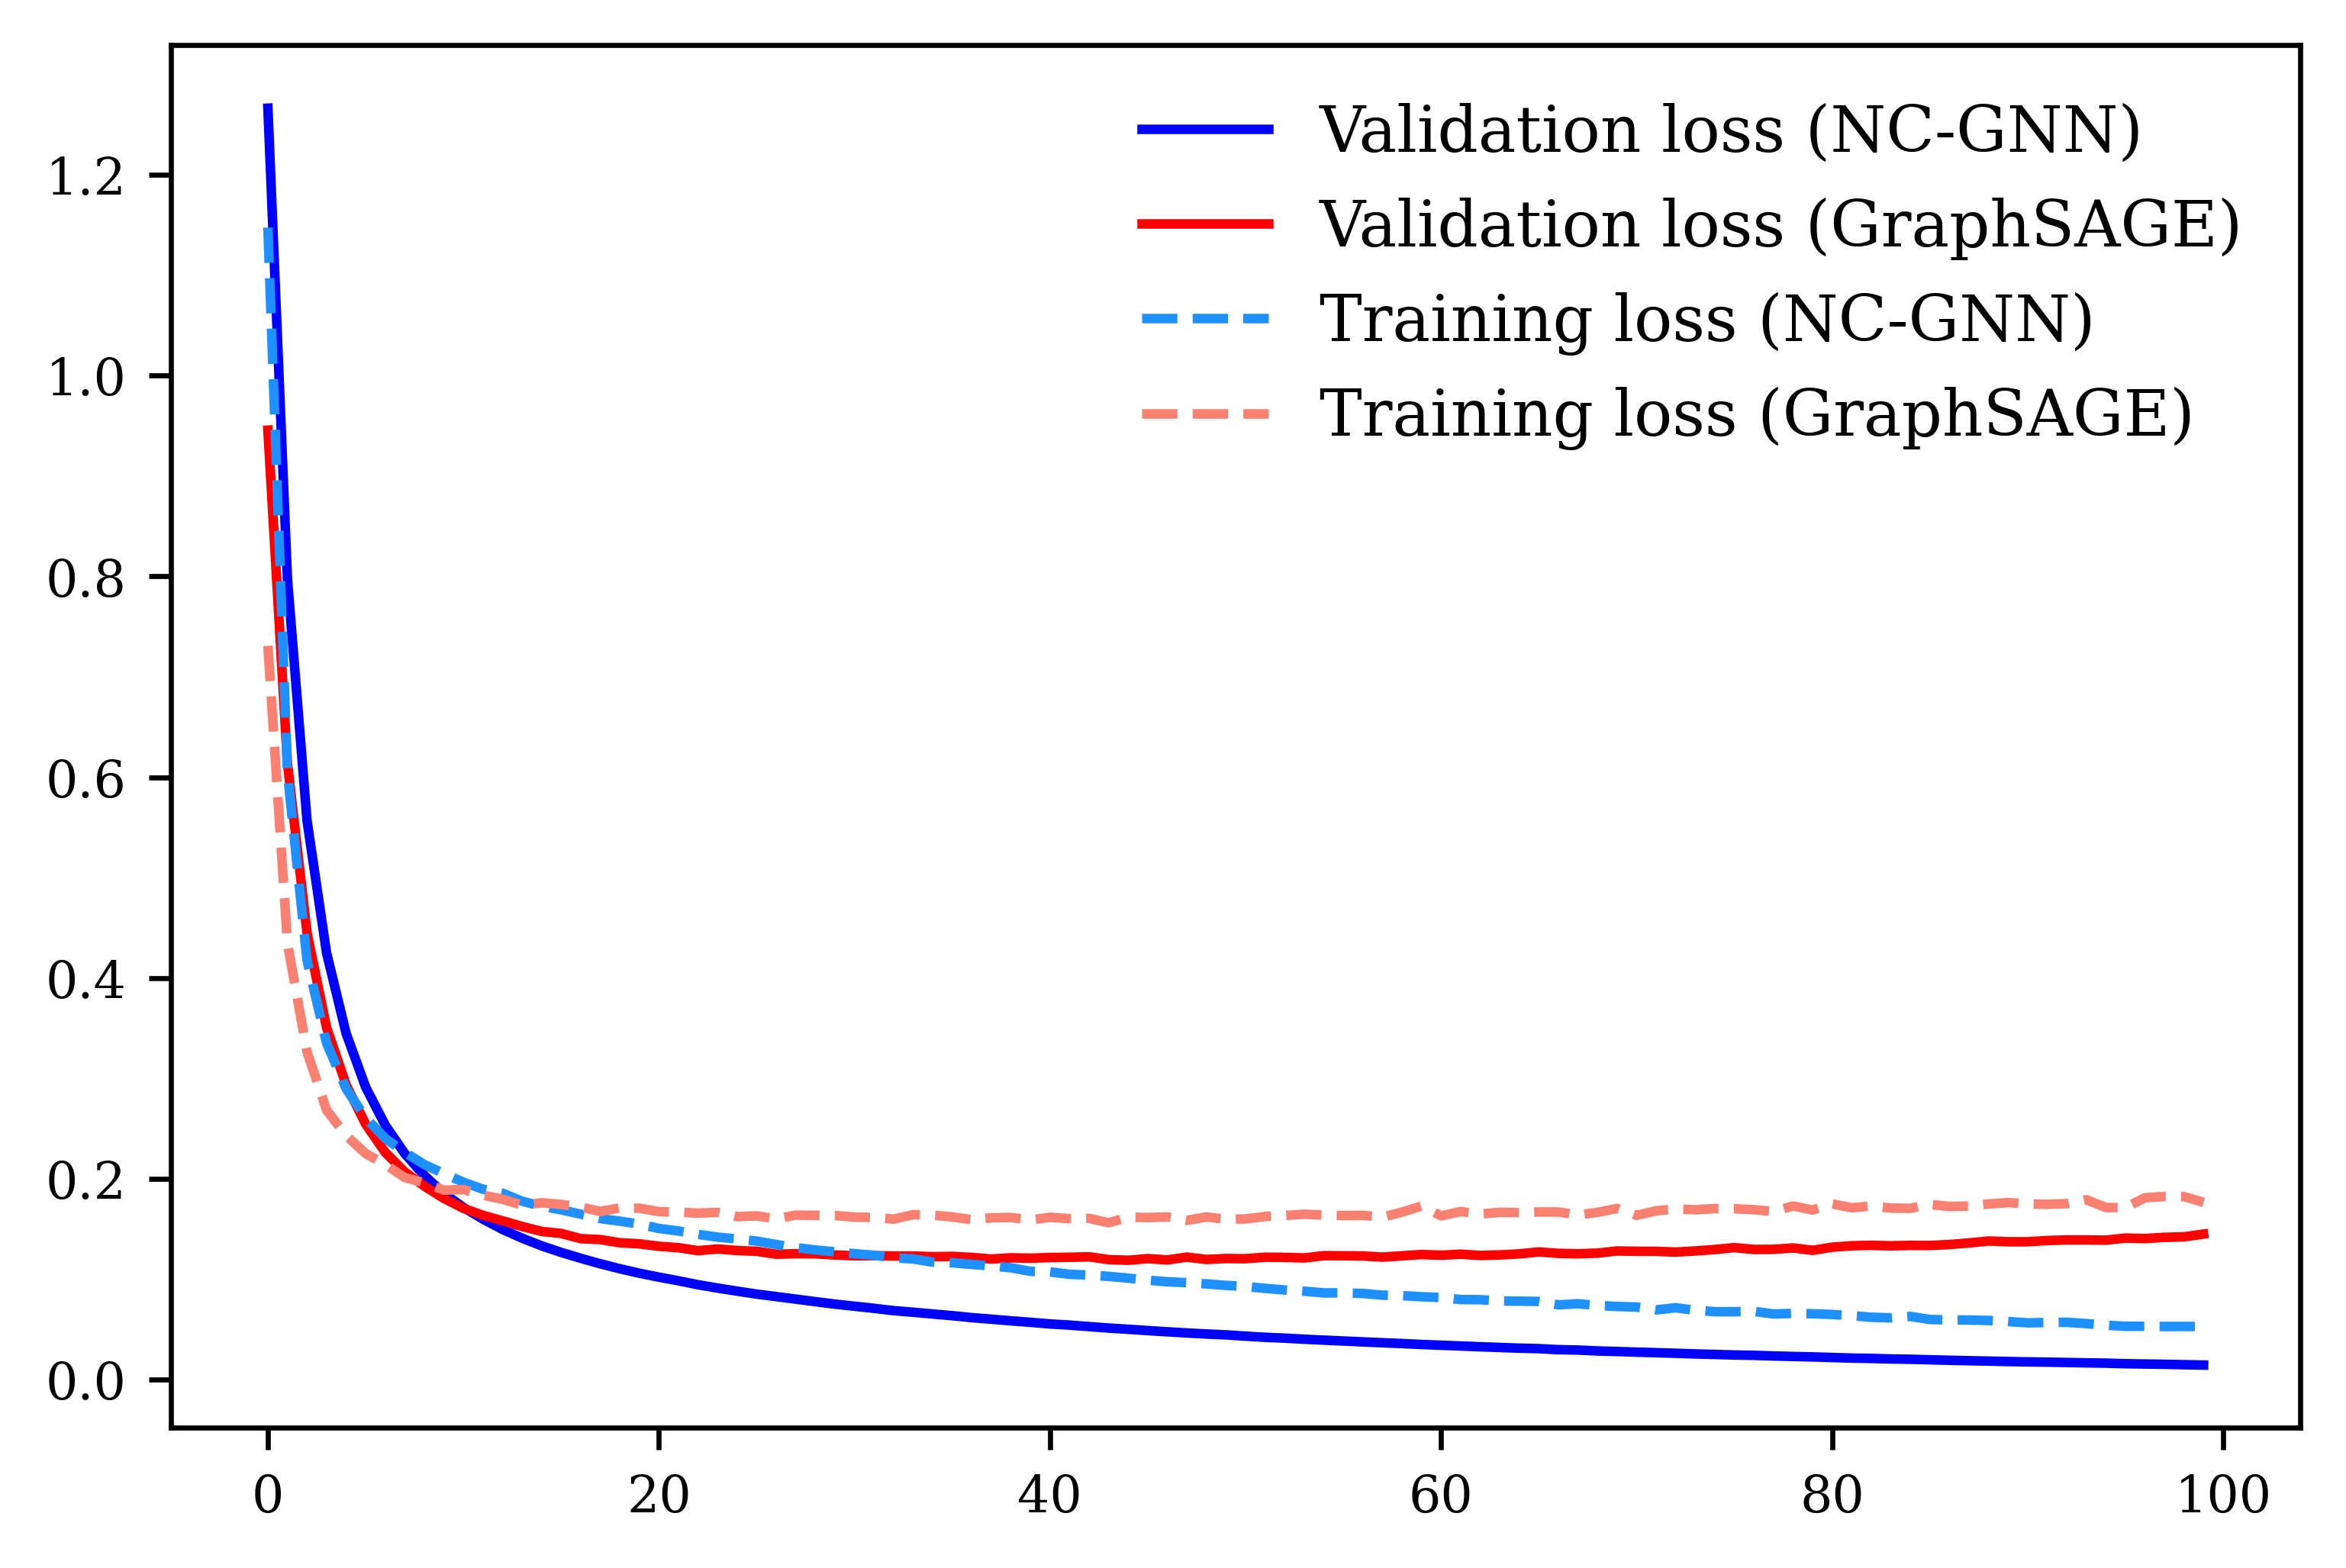

In [34]:
import matplotlib.pyplot as plt
with plt.style.context(['ieee']): 
    fig, ax = plt.subplots(figsize=(6,4))

    ax.plot(loss_ncgnn[0],'-',color='b',label='Validation loss (NC-GNN)')
    ax.plot(loss_ncgnn[1],'-',color='r',label='Validation loss (GraphSAGE)')
    ax.plot(loss_sage[0],'--',color='dodgerblue',label='Training loss (NC-GNN)')
    ax.plot(loss_sage[1],'--',color='salmon',label='Training loss (GraphSAGE)')
    ax.legend(fontsize=10,loc=1,frameon=False)

In [37]:
save_list('/Users/zhihaodong/Downloads/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/loss.pkl',[loss_mlp,loss_sage,loss_ncgnn])

In [8]:
training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,0)

In [10]:
    acc_lists = []    
    #new_adjs = {}
    #for key in full_adjs:
    #    neighbs_set = full_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(full_adjs[node] & neighbs_set)
    #    new_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_adjs[key].add((node,n_list.count(node)))
    #new_training_adjs = {}
    #for key in training_adjs:
    #    neighbs_set = training_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(training_adjs[node] & neighbs_set)
    #    new_training_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_training_adjs[key].add((node,n_list.count(node)))
            
    for j in range(20):
        print(j)
        acc_list = []
        for i in range(0,11):
            acc_list.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.5*i,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)[2])
        acc_lists.append(acc_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [21]:
    acc_lists_com = []    
    #new_adjs = {}
    #for key in full_adjs:
    #    neighbs_set = full_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(full_adjs[node] & neighbs_set)
    #    new_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_adjs[key].add((node,n_list.count(node)))
    #new_training_adjs = {}
    #for key in training_adjs:
    #    neighbs_set = training_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(training_adjs[node] & neighbs_set)
    #    new_training_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_training_adjs[key].add((node,n_list.count(node)))
            
    for j in range(20):
        print(j)
        acc_list = []
        for i in range(11,13):
            acc_list.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.5*i,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)[2])
        acc_lists_com.append(acc_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [28]:
acc_list_new = []
for i in range(len(acc_lists)):
    j = acc_lists[i] + acc_lists_com[i]
    acc_list_new.append(j)

In [30]:
(acc_list_new[0])

[0.9540094339622641,
 0.9554834905660378,
 0.9599056603773585,
 0.9610849056603774,
 0.9609375,
 0.9622641509433962,
 0.9635908018867925,
 0.965064858490566,
 0.9644752358490566,
 0.9658018867924528,
 0.9665389150943396,
 0.9658018867924528,
 0.9665389150943396]

In [26]:
a = [1,2]+([3,4])
a

[1, 2, 3, 4]

In [31]:
acc_array = np.array(acc_list_new)

In [32]:
acc_array.shape

(20, 13)

In [33]:
import matplotlib.pyplot as plt

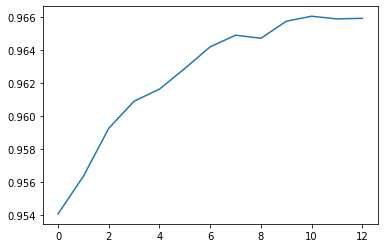

In [34]:
plt.plot(np.mean(acc_array,axis=0))

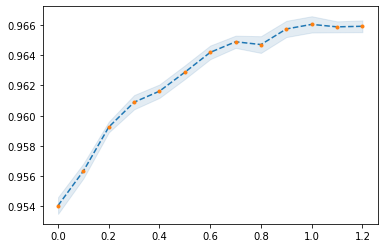

In [35]:
plt.plot([i*0.1 for i in range(13)],np.mean(acc_array,axis=0),'--')
plt.plot([i*0.1 for i in range(13)],np.mean(acc_array,axis=0),'.')
plt.fill_between([i*0.1 for i in range(13)],np.mean(acc_array,axis=0)-np.std(acc_array,axis=0),np.mean(acc_array,axis=0)+np.std(acc_array,axis=0),color='steelblue',alpha=0.15)


In [36]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/acc_array_20.pkl',acc_array)

In [36]:
a = 9
a

9

In [37]:
-a

-9

In [39]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
pca = PCA(n_components=300)

In [40]:
%time feat_data_half = pca.fit_transform(feat_data)

CPU times: user 4min 2s, sys: 13.4 s, total: 4min 15s
Wall time: 14.4 s


In [41]:
rand_clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
rand_clf.fit(feat_data,labels.squeeze())

RandomForestClassifier(n_jobs=-1)

In [42]:
a = rand_clf.feature_importances_

In [43]:
c = np.argpartition(a, -200)[-200:]
c

array([4952, 6208, 1469, 2371, 2029,  228, 4060, 3013, 2283, 7586, 7405,
       4839, 5640, 4402, 7786,  501, 3851, 3551, 3233,  395, 5137, 3869,
        662,  537, 1480, 4546, 2234, 5073, 3454, 5058, 5242, 3464, 4031,
       4694, 3944, 4983, 5200, 5336, 6049, 5323, 4807, 1634, 4380, 2662,
       2167, 7793, 2836, 5066, 3693, 3240, 3034, 5070, 2511, 3697, 3887,
       3899, 6214, 6144, 2124, 5492, 5132, 2208, 3325, 3283, 6218, 6321,
       1680, 3207, 6194, 7758, 5004, 7315, 3961, 4068, 7303, 4520, 4064,
       7209, 7174, 3333, 7515, 8095, 6331, 7219, 2785, 1473, 8375, 1210,
       5076, 7306, 6137, 5223,  408, 7304, 6127, 6124, 7096, 1105, 7845,
       5182, 6146, 2245, 5308, 4360, 5178, 1277, 3262, 5172, 3008, 3009,
       7357, 4403, 5169, 5391, 4251, 2218, 7494, 3436, 2152, 2643, 5969,
       7917, 1569, 7143, 5453, 5493, 6175, 6179, 3447, 3917, 6262, 4458,
       5891, 2215, 3074,  289, 5574, 1219, 1748,  494, 6216, 5589, 5605,
       4058, 1504, 4557, 6659, 1464, 2510,  934,  1

In [48]:
feat_data.shape[1]

8415

In [57]:
random.sample(range(10),5)


[4, 2, 0, 9, 3]

In [58]:
random.sample(range(10),5)


[5, 1, 3, 9, 2]

In [59]:
random.seed(10)
a = random.sample(range(feat_data.shape[1]),int(feat_data.shape[1]*0.1))


In [62]:
b = feat_data[:,a]

In [65]:
pwd

'/home/zhihao/Document/gnn_fd/graphSage/split/multihead/NCGNN_reorderedge'

In [45]:
feat_data.shape

(34493, 8415)

In [7]:

results_mlp_r = []
    
for seed in range(5):
    import torch
    from torch import nn
    from torch.nn import ReLU
    
    from torch.autograd import Variable
    from sklearn.metrics import f1_score,accuracy_score
    import glob
    import os
    import time
    batch_size = 128
    t_total = time.time()
    loss_values = []
    loss_train = []
    bad_counter = 0
    epochs = 200
    best = epochs + 1
    best_epoch = 0   
    temp_path = './academic_phy/'
    patience = 5
    num_class = 5
    hidden_num = 128
    lr = 0.0001
    #results = []
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    class MLPModel(nn.Module):
        def __init__(self,num_classes,hidden_dim,feature_dim):
            super(MLPModel,self).__init__()
            self.hidden = nn.Linear(feature_dim,hidden_dim)
            self.layer = nn.Linear(hidden_dim,num_classes)
            self.xent = nn.CrossEntropyLoss()
            self.act1 = ReLU()
        def forward(self,nodes):
            X = self.hidden(nodes)
            X = self.act1(X)
            scores = self.layer(X)
            return scores
        def loss(self,nodes,labels):
            scores = self.forward(nodes)
            return self.xent(scores,labels.squeeze())
        
    mlp = MLPModel(num_class,hidden_num,feat_data_half.shape[1] )
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)
    
    
    for epoch in range(epochs):
        random.shuffle(training)
        num_batches = int(len(training) / batch_size) + 1
        train_losses = []
        start_time = time.time()
        for batch in range(num_batches):   
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(training))
            batch_nodes = training[i_start:i_end]
            
            optimizer.zero_grad()
            loss = mlp.loss(Variable(torch.Tensor(feat_data_half[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            train_losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
    
        
        num_batches_valid = int(len(validation) / batch_size) 
        valid_losses = []
        for batch in range(num_batches_valid):
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(validation))
            batch_nodes = validation[i_start:i_end]
    
            loss = mlp.loss(Variable(torch.Tensor(feat_data_half[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            valid_losses.append(loss.data.item())
       
        
        loss_train.append(np.average(train_losses))
        loss_values.append(np.average(valid_losses))
        torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
        if loss_values[-1] < best:
            best = loss_values[-1]
            best_epoch = epoch 
            bad_counter = 0
        else:
            bad_counter += 1
        if bad_counter == patience:
            break
        files = glob.glob(temp_path+'*.pkl')
        for file in files:
            epoch_nb = int(file[len(temp_path):].split('.')[0])
            if epoch_nb < best_epoch:
                os.remove(file)
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb > best_epoch:
            os.remove(file)
    #print("Optimization Finished!")
    #print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
    print(best_epoch)
    
    num_batches_test = int(len(testing) / batch_size) 
    test_outputs = []
    test_labels = []
    for batch in range(num_batches_test):
        i_start = batch * batch_size
        i_end = (batch + 1) * batch_size
        batch_nodes = testing[i_start:i_end]
        test_output = torch.zeros(batch_size,num_class)
        for i in range(3):
            test_output = test_output + mlp.forward(torch.Tensor(feat_data_half[np.array(batch_nodes)]))
        
        test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
        test_labels.extend(list(labels[batch_nodes]))
        
    accuracy_score(test_labels,test_outputs)
    results_mlp_r.append([loss_train,loss_values,accuracy_score(test_labels,test_outputs)])

53
42
47
33
48


In [9]:
results_sagegcn_best_r = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    res = train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)   
    for i in range(3,6):
        temp = train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,1*i,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    
    results_sagegcn_best_r.append(res)










KeyboardInterrupt: 

In [ ]:
results_sagegcn_0_r = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    #full_adjs,training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,adj,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    results_sagegcn_0_r.append(train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)
)

In [13]:
a = []
for i in results_mlp_r:
    a.append(i[2])
(a)

[0.9582841981132075,
 0.9638856132075472,
 0.9612323113207547,
 0.9613797169811321,
 0.9599056603773585]

In [12]:
d_coauther_phy_mlp = [0.9641804245283019,
 0.9669811320754716,
 0.9683077830188679,
 0.9696344339622641,
 0.9694870283018868,
 0.9674233490566038,
 0.9668337264150944,
 0.9659492924528302,
 0.9662441037735849,
 0.9660966981132075]

In [9]:
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,0)
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))

    train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,200,5,5,'./academic_phy/',hidden=128,lr=0.0001,batch_size=128)

[[1.1488490546191181,
  0.6941068179813432,
  0.488878368779465,
  0.3821711887915929,
  0.31849151187472874,
  0.2784036099910736,
  0.25109413588120616,
  0.2321576543704227,
  0.2179706219445776,
  0.2055887456661389,
  0.19649840459043597,
  0.18868669642158498,
  0.18271795812028427,
  0.17666548297361093,
  0.17135767689273682,
  0.1663269868787424,
  0.16328238958009966,
  0.15977699254397992,
  0.15499381044948543,
  0.15126725587487957,
  0.14894846311689894,
  0.14573772718417055,
  0.14223639844100416,
  0.14000093840338565,
  0.1380157523593049,
  0.13497755934058883,
  0.1335686946540703,
  0.1315490850649866,
  0.1284707348195859,
  0.1264298248714135,
  0.12426280322266214,
  0.12215248398758748,
  0.12017889451925401,
  0.11806386341283351,
  0.11547939405765062,
  0.11485132041536732,
  0.11334375892248419,
  0.1115631014338614,
  0.10859594766602472],
 [0.822017472869945,
  0.5296413791629503,
  0.38851812200726205,
  0.31412906016943587,
  0.26960176651207907,
  0.23

In [10]:
train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.5,200,5,5,'./academic_phy/',hidden=128,lr=0.0001,batch_size=128)[2]

0.9528301886792453

In [11]:
train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,1,200,5,5,'./academic_phy/',hidden=128,lr=0.0001,batch_size=128)[2]

0.9554834905660378

In [14]:
train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,3,200,5,5,'./academic_phy/',hidden=128,lr=0.0001,batch_size=128)[2]

0.9612323113207547

In [12]:
train_1(False,False,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,3,200,5,5,'./academic_phy/',hidden=128,lr=0.0001,batch_size=128)[2]

0.9624115566037735

# concatenation

In [4]:
cancat_results_sagegcn_0_1 = []
cancat_results_sagegcn_0_2l = []
cancat_results_sagegcn_0_3l = []

for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    cancat_results_sagegcn_0_1.append(train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128))        
    #cancat_results_sagegcn_0_2l.append(train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128))
    #cancat_results_sagegcn_0_3l.append(train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128))



In [13]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/concat/sage_0_1.pkl',cancat_results_sagegcn_0_1)
#save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/concat/sage_0_2l.pkl',cancat_results_sagegcn_0_2l)
#save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/concat/sage_0_3l.pkl',cancat_results_sagegcn_0_3l)

In [14]:
a = []
for i in cancat_results_sagegcn_0_1:
    a.append(i[2])
sum(a)

9.696786556603774

In [15]:
a = []
for i in cancat_results_sagegcn_0_2l:
    a.append(i[2])
sum(a)

0

In [16]:
a = []
for i in cancat_results_sagegcn_0_3l:
    a.append(i[2])
sum(a)

0

In [4]:
cancat_results_sagegcn_best_1 = []
cancat_results_sagegcn_best_2l = []
cancat_results_sagegcn_best_3l = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    res = train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)   
    for i in range(1,6):
        temp = train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,1*i,500,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_1.append(res)
    
    #res = train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)   
    #for i in range(1,6):
    #    temp = train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,1*i,500,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)
    #    if res[2] < temp[2]:
    #        res = temp 
    #cancat_results_sagegcn_best_2l.append(res)
    #
    #res = train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)   
    #for i in range(1,6):
    #    temp = train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,1*i,500,5,5,'./academic_phy/',hidden=128,lr=0.00003,batch_size=128)
    #    if res[2] < temp[2]:
    #        res = temp 
    #cancat_results_sagegcn_best_3l.append(res)


In [7]:
a = []
for i in cancat_results_sagegcn_best_1:
    a.append(i[2])
sum(a)

9.70091391509434

In [6]:
a = []
for i in cancat_results_sagegcn_best_2l:
    a.append(i[2])
sum(a)

0

In [ ]:
a = []
for i in cancat_results_sagegcn_best_3l:
    a.append(i[2])
sum(a)

In [12]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/coauthor_phy/concat/sage_best_1.pkl',cancat_results_sagegcn_best_1)
